# Analyze lists of outliers in the MTT and LDH predictions

In [1]:
# Imports
import polars as pl
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests

In [ ]:
# Create MOTIVE target sets

## MTT outlier analysis

In [5]:
preds = pl.read_parquet("../../1_snakemake/outputs/cellprofiler/mad_featselect/classifier_results/axiom_continuous_predictions.parquet")
meta = pl.read_parquet("../../1_snakemake/inputs/metadata/metadata.parquet").drop(["Metadata_Compound", "Metadata_Log10Conc"])
pods = pl.read_parquet("../../1_snakemake/outputs/cellprofiler/mad_featselect/curves/pods.parquet")
preds = preds.join(meta, on=["Metadata_Plate", "Metadata_Well"])
preds = preds.join(pods, on="Metadata_Compound", how="left")
preds = preds.with_columns(
    pl.when(pl.col("Metadata_Compound") == "DMSO").then(pl.lit("DMSO")).otherwise(pl.lit("Compound")).alias("Well_type")
)

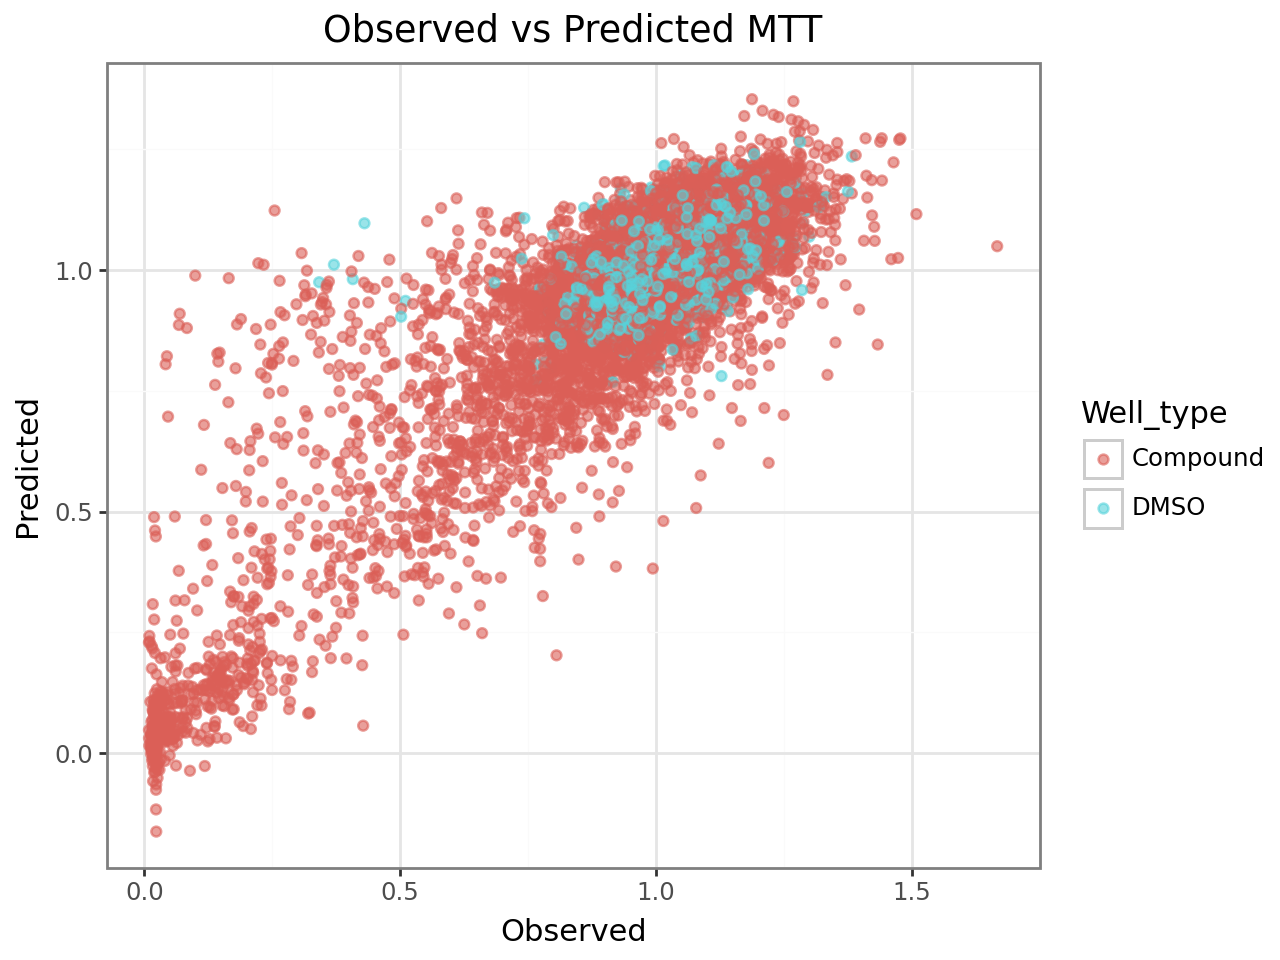

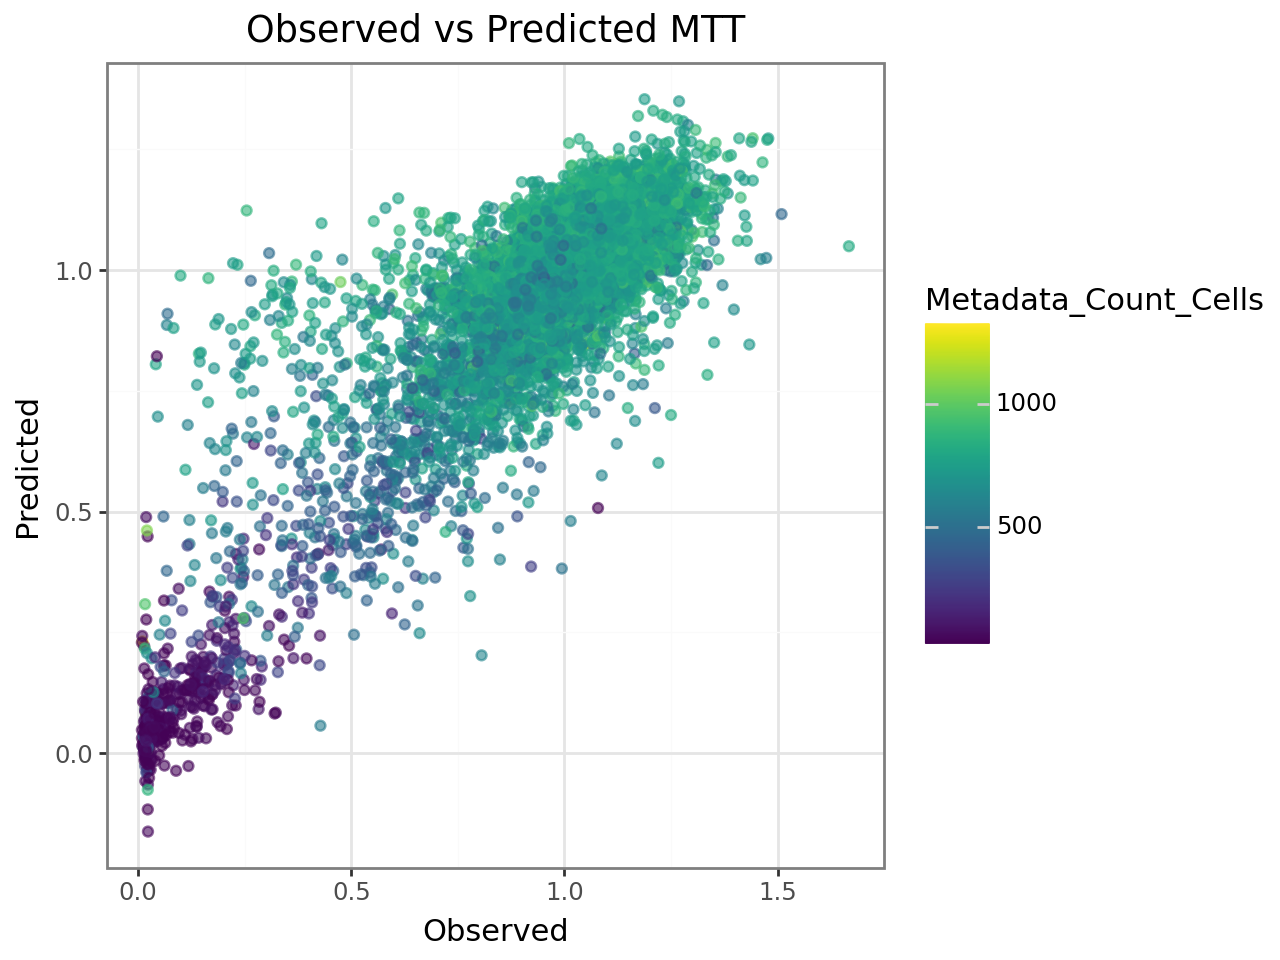

In [ ]:
from plotnine import aes, geom_point, ggplot, labs, theme_bw
import plotnine as pn

plot1 = (
    ggplot(preds.filter(pl.col("Variable_Name") == "Metadata_mtt_normalized"), aes(x="Observed", y="Predicted", color="Well_type"))
    + geom_point(alpha=0.6)
    + labs(
        x="Observed",
        y="Predicted",
        title="Observed vs Predicted MTT",
    )
    + theme_bw()
)
plot1.show()

plot1 = (
    ggplot(preds.filter(pl.col("Variable_Name") == "Metadata_mtt_normalized"), aes(x="Observed", y="Predicted", color="Metadata_Count_Cells"))
    + geom_point(alpha=0.6)
    + labs(
        x="Observed",
        y="Predicted",
        title="Observed vs Predicted MTT",
    )
    + theme_bw()
)
plot1.show()

In [12]:
# Get residuals of the 1:1 line
mtt = preds.filter(pl.col("Variable_Name") == "Metadata_mtt_normalized")

mtt = mtt.with_columns(
    (pl.col("Predicted") - pl.col("Observed")).alias("Diff_pred_obs")
)

In [10]:
# Get outliers
std = mtt.select(pl.col("Diff_pred_obs").std()).to_numpy()[0][0]
thresh = std*2.58 # 2.58 std = p-val 0.01

mtt = mtt.with_columns(
    pl.when(pl.col("Diff_pred_obs") > thresh)
      .then(pl.lit("Higher"))
      .when(pl.col("Diff_pred_obs") < (-1*thresh))
      .then(pl.lit("Lower"))
      .otherwise(pl.lit("Normal")).alias("Outlier_flag"),
    pl.concat_str(["Metadata_Perturbation", "Metadata_Well", "Metadata_Plate"], separator="_").alias("Unique_ID"),
)

print(mtt.shape)
mtt.select(pl.col("Outlier_flag").value_counts()).unnest("Outlier_flag")

(21815, 45)


Outlier_flag,count
str,u32
"""Higher""",295
"""Lower""",172
"""Normal""",21348


/dgx1nas1/storage/data/jess/miniforge3/envs/axiom/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 230'. Pick better value with 'binwidth'.


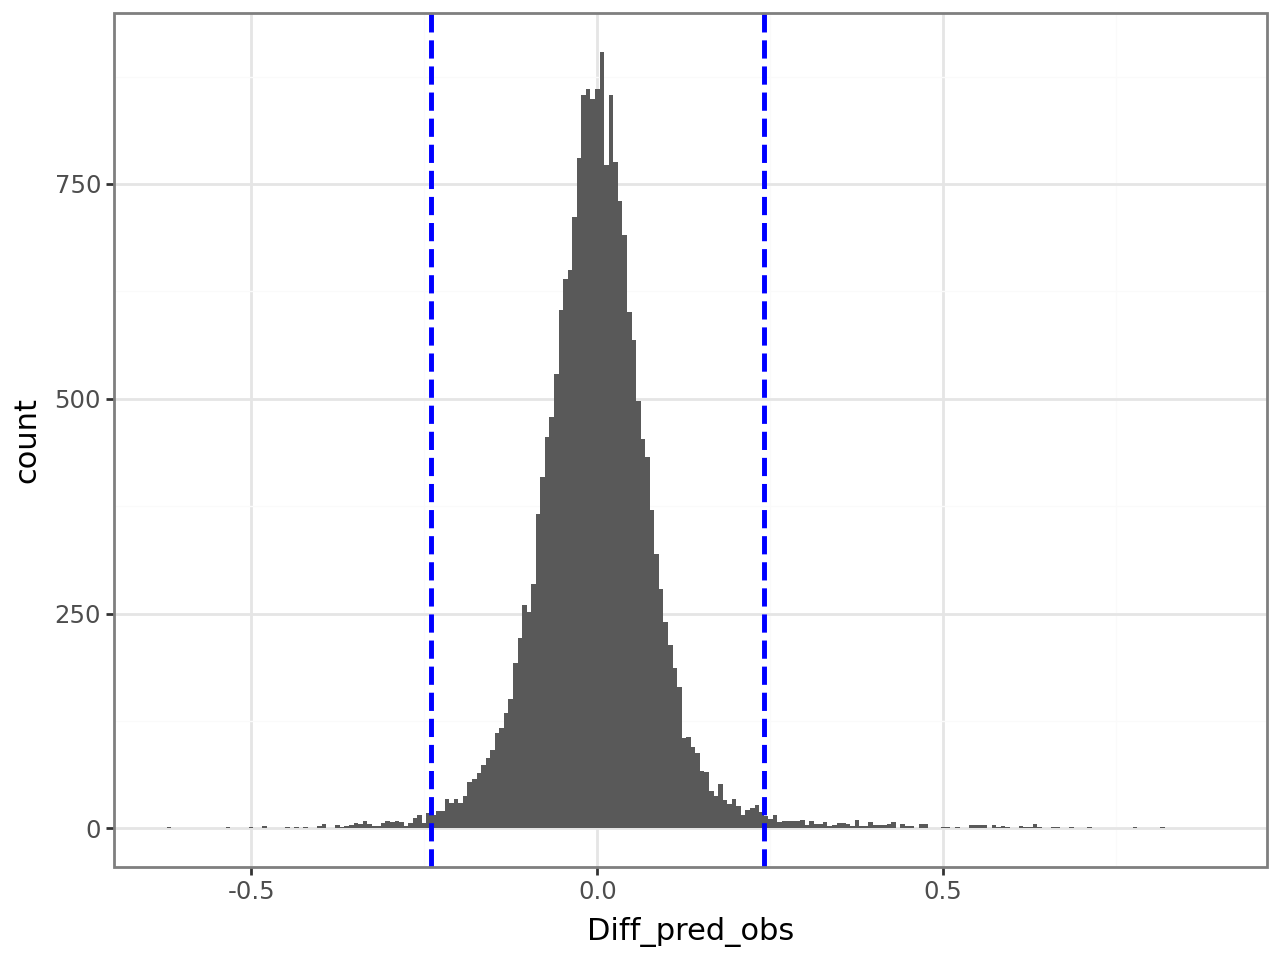

In [21]:
from plotnine import geom_histogram, geom_vline

plot1 = (
    ggplot(mtt, aes(x="Diff_pred_obs"))
    + geom_histogram()
    + geom_vline(xintercept=thresh, color="blue", linetype="dashed", size=1)
    + geom_vline(xintercept=(-thresh), color="blue", linetype="dashed", size=1)
    + labs(
        x="Diff_pred_obs",
    )
    + theme_bw()
)
plot1.show()

In [ ]:
# Define enrichment analysis functions

In [ ]:
# Analyze MTT outliers

In [ ]:
# Analyze LDH outliers